<h1 align="center">Behavior Cloning P3 Project</h1>

In [1]:
import csv
import cv2
import numpy as np
import sklearn

In [2]:
#################################################################################
#
# Read CVS file and filter out straight lines according to TakeCount variable
# assumption: first line of CVS is comment
# 
#################################################################################

lines = []

comment_blocker  = True         # ignore commment 1st line


# Straight-line filter
count       = 0
removed     = 0
number      = 0
TakeCount   = 10 # every TakeCount take a straight line
    
# Open CSV file
with open ('./Data/driving_log.csv') as csvfile :
    reader = csv.reader(csvfile)
    for line in reader :
        
        # Comment blocker only needed for reference
        if comment_blocker :            
            comment_blocker = False
            continue
        
        # Check steering value straight
        if (float(line[3]) == 0) :
            number = number + 1        # count straight lines  
            count  = count + 1         # count until TakeCount 
            if (count == TakeCount) :
                lines.append(line)     # add straight
                count = 0
            else :
                removed = removed + 1  # removed lines
        else :
            # add 
            lines.append(line)         # add non straight
        
                    
print ()
print ('** debug: list size:',len(lines))
print ('** debug: straight lines - removed',removed,'of',number,'lines')
print ()


** debug: list size: 11556
** debug: straight lines - removed 7123 of 7914 lines



In [3]:
#################################################################################
#
# Create Camera list (centre, left, right)
#
#################################################################################

steering_correction = 0.25

# master list
name_list_cam       = []
steering_list_cam   = []
# detail lists
name_list_cam_c     = []
steering_list_cam_c = []
name_list_cam_l     = []
steering_list_cam_l = []
name_list_cam_r     = []
steering_list_cam_r = []

for x in lines :

    # Centre Camera
    name     = './Data/IMG/' + x[0].split('/')[-1]
    steering = float(x[3])
    name_list_cam_c.append(name)
    steering_list_cam_c.append(steering)
    # Left Camera
    name     = './Data/IMG/' + x[1].split('/')[-1]
    steering = float(x[3]) + steering_correction
    name_list_cam_l.append(name)
    steering_list_cam_l.append(steering)
    # Right Camera
    name     = './Data/IMG/' + x[2].split('/')[-1]
    steering = float(x[3]) - steering_correction
    name_list_cam_r.append(name)
    steering_list_cam_r.append(steering)

    
# build master list
name_list_cam     = name_list_cam_c + name_list_cam_l + name_list_cam_r 
steering_list_cam = steering_list_cam_c + steering_list_cam_l + steering_list_cam_r

In [4]:
# libraries for plotting
import numpy as np
import scipy.stats as stats
import pylab as pl
import matplotlib.pyplot as plt
%matplotlib inline

Center Camera - Steering Angle: mean 0.0151630268898 derivation 0.143623859592 number of samples 11556


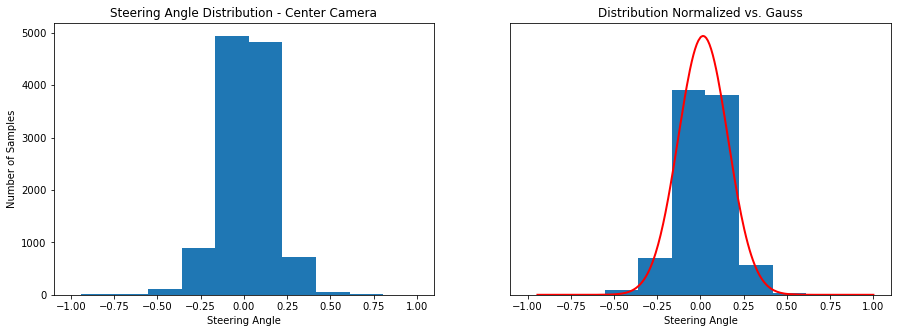

In [5]:
#################################################################################
#
# Print Steering Angle Distribution of Centre Camera
#
#################################################################################

# calc mean & derivation
data_c = sorted(steering_list_cam_c)
fit_c = stats.norm.pdf(data_c, np.mean(data_c), np.std(data_c)) 

print ('Center Camera - Steering Angle: mean',np.mean(data_c),'derivation',np.std(data_c),'number of samples',len(steering_list_cam_c))

# plot area
plt.rcParams["figure.figsize"] = [15, 5]

sub = plt.subplot(1,2,1)
plt.title('Steering Angle Distribution - Center Camera')
plt.xlabel('Steering Angle')
plt.ylabel('Number of Samples')
sub.set_xlim([-1.1,1.1])
pl.hist(data_c)

sub = plt.subplot(1,2,2)
plt.title('Distribution Normalized vs. Gauss')
plt.xlabel('Steering Angle')
sub.set_xlim([-1.1,1.1])
sub.set_yticks(())
pl.plot(data_c,fit_c,'-r',linewidth=2.0)
pl.hist(data_c,normed=True)
pl.show()



3 x Cameras - Steering Angle: mean 0.0151630268898 derivation 0.249588620956 number of samples 34668


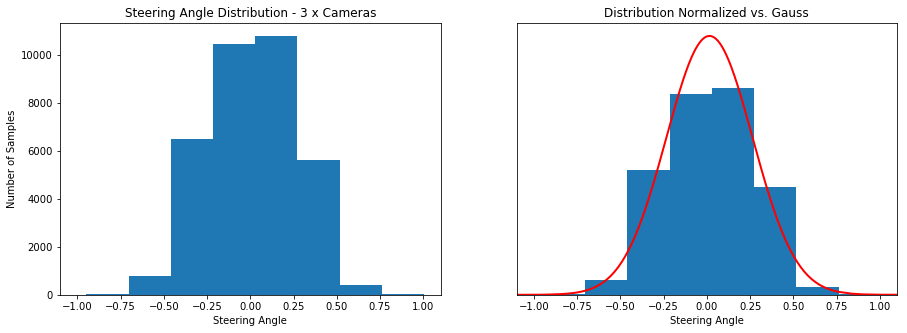

In [6]:
#################################################################################
#
# Print Steering Angle Distribution of 3 x Cameras
#
#################################################################################

# calc mean & derivation
data   = sorted(steering_list_cam)
fit   = stats.norm.pdf(data, np.mean(data), np.std(data)) 

print ('3 x Cameras - Steering Angle: mean',np.mean(data),'derivation',np.std(data),'number of samples',len(steering_list_cam))

# plot area
plt.rcParams["figure.figsize"] = [15, 5]

sub = plt.subplot(1,2,1)
plt.title('Steering Angle Distribution - 3 x Cameras')
plt.xlabel('Steering Angle')
plt.ylabel('Number of Samples')
sub.set_xlim([-1.1,1.1])
pl.hist(data)

sub = plt.subplot(1,2,2)
plt.title('Distribution Normalized vs. Gauss')
plt.xlabel('Steering Angle')
sub.set_xlim([-1.1,1.1])
sub.set_yticks(())
pl.plot(data,fit,'-r',linewidth=2.0)
pl.hist(data,normed=True)
pl.show()


In [7]:
#################################################################################
#
# Image jittering according to Vivek Yadav 
# (https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9)
#
#################################################################################

def trans_image(image,steer,trans_range):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 40*np.random.uniform()-40/2
    #tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang

In [8]:
#################################################################################
#
# Create augmentation file
#
#################################################################################

name_list_aug = []
steering_list_aug = []

steering_threshold = 0.21

TYPE1 = 100.0

for i in range(len(name_list_cam)) :

        # Flip = AUG_TYPE1
        if (abs(steering_list_cam[i]) > steering_threshold) :
            name_list_aug.append(name_list_cam[i])
            steering_list_aug.append(steering_list_cam[i]*-1.0)
            
            
print ('Augmented Data size',len(steering_list_aug),'for steering threshold of',steering_threshold)
            
# New data
name_list_full     = name_list_cam + name_list_aug
steering_list_full = steering_list_cam + steering_list_aug

Augmented Data size 16200 for steering threshold of 0.21


Camera & Augmented Data - Steering Angle: mean -0.000490209639085 derivation 0.283083521041 number of samples 50868


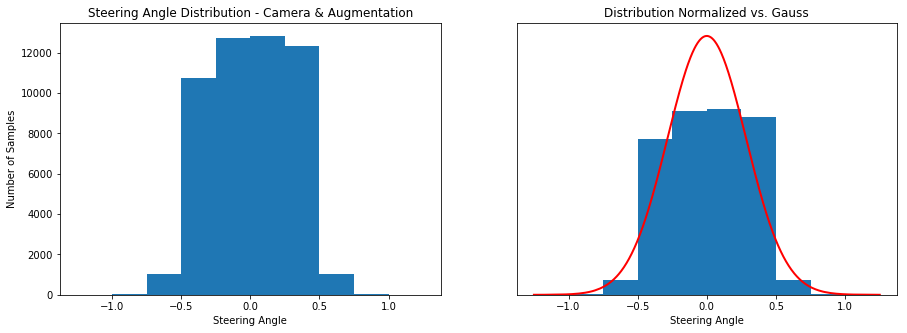

In [9]:
#################################################################################
#
# Print Steering Angle with Augmentation
#
#################################################################################

data_f = sorted(steering_list_full)
fit_f = stats.norm.pdf(data_f, np.mean(data_f), np.std(data_f)) 

print ('Camera & Augmented Data - Steering Angle: mean',np.mean(data_f),'derivation',np.std(data_f),'number of samples',len(steering_list_full))


plt.rcParams["figure.figsize"] = [15, 5]

sub = plt.subplot(1,2,1)
plt.title('Steering Angle Distribution - Camera & Augmentation')
plt.xlabel('Steering Angle')
plt.ylabel('Number of Samples')
#sub.set_xlim([-1.1,1.1])
pl.hist(data_f)

sub = plt.subplot(1,2,2)
plt.title('Distribution Normalized vs. Gauss')
plt.xlabel('Steering Angle')
#sub.set_xlim([-1.1,1.1])
sub.set_yticks(())
pl.plot(data_f,fit_f,'-r',linewidth=2.0)
pl.hist(data_f,normed=True)
pl.show()

In [10]:
# Update Augmented list in terms of steering for furhter processing

for u in range(len(steering_list_aug)) :
    steering_list_aug[u] = steering_list_aug[u] + TYPE1 # add AUG type label

print ('Updated Augmented Steering Angle:',TYPE1,'element 0 =',steering_list_aug[0])


Updated Augmented Steering Angle: 100.0 element 0 = 99.6320471


In [11]:
#################################################################################
#
# Pre-processing for CNN: 
# input image:   160x320x3 BGR
# process:       crop top by 60, bottom by 20, resize to 66x200x3, color BGR2YUV
# output imsage: 66x200x3 YUV
#
#################################################################################
import cv2

def process66x200 (image) :
    # crop 60 from top, remove 20 from bottom
    image_p = image[60:140,:]
    # resize
    image_p = cv2.resize(image_p,(200, 66))
    # color convert
    return cv2.cvtColor(image_p, cv2.COLOR_BGR2YUV)


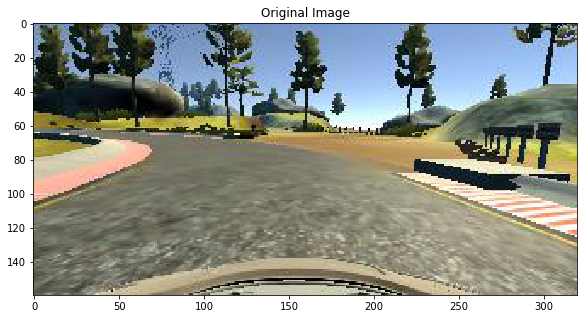

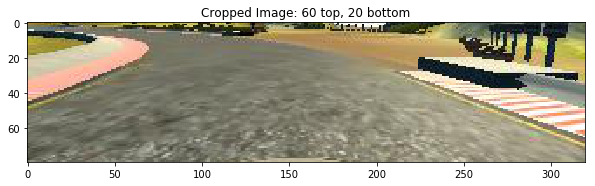

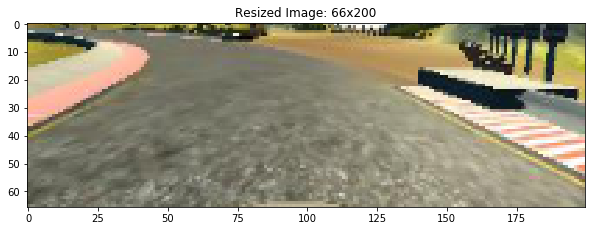

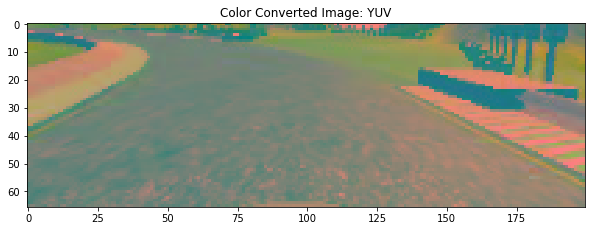

In [12]:
#################################################################################
#
# Print images pre-processing steps
#
#################################################################################

plt.rcParams["figure.figsize"] = [10, 5]
img = cv2.imread(name_list_cam_c[0])
crop_img = img[60:140, :] 
final_img = cv2.resize(crop_img,(200, 66))

plt.title('Original Image')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pl.imshow(img)
pl.show()

plt.title('Cropped Image: 60 top, 20 bottom')
crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
pl.imshow(crop_img)
pl.show()

plt.title('Resized Image: 66x200')
final = cv2.cvtColor(final_img, cv2.COLOR_BGR2YUV)
final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
pl.imshow(final_img)
pl.show()

plt.title('Color Converted Image: YUV')
pl.imshow(final)
pl.show()
                                   

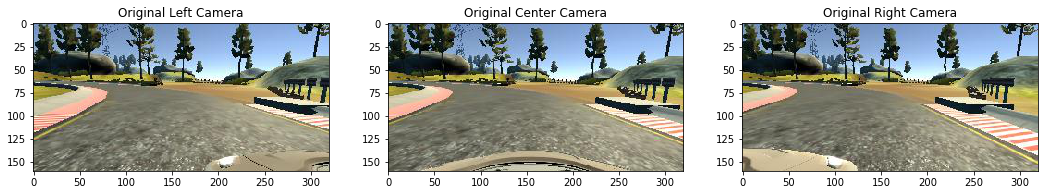

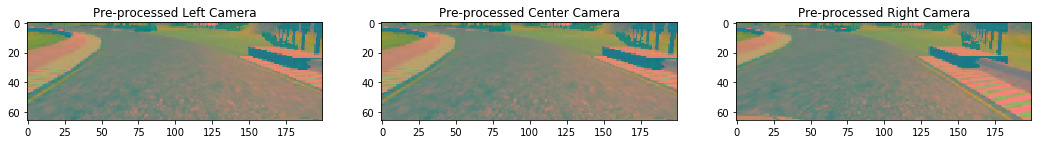

In [13]:
#################################################################################
#
# Print Pre-processing images of 3 x Cameras (orig vs. pre-processed)
#
#################################################################################

plt.rcParams["figure.figsize"] = [18, 6]

# original images 
sub = plt.subplot(2,3,1)
plt.title('Original Left Camera')
img1 = cv2.imread(name_list_cam_l[0])
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
pl.imshow(img1)
sub = plt.subplot(2,3,2)
plt.title('Original Center Camera')
img2 = cv2.imread(name_list_cam_c[0])
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
pl.imshow(img2)
sub = plt.subplot(2,3,3)
plt.title('Original Right Camera')
img3 = cv2.imread(name_list_cam_r[0])
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
pl.imshow(img3)
pl.show()

# pre-processed
sub = plt.subplot(2,3,1)
plt.title('Pre-processed Left Camera')
img1 = cv2.imread(name_list_cam_l[0])
img1 = process66x200(img1)
pl.imshow(img1)
sub = plt.subplot(2,3,2)
plt.title('Pre-processed Center Camera')
img2 = cv2.imread(name_list_cam_c[0])
img2 = process66x200(img2)
pl.imshow(img1)
sub = plt.subplot(2,3,3)
plt.title('Pre-processed Right Camera')
img3 = cv2.imread(name_list_cam_r[0])
img3 = process66x200(img3)
pl.imshow(img3)
pl.show()

 

In [14]:
#################################################################################
#
# Generator
# uses process66x200()
#
#################################################################################

import cv2
import numpy as np
import sklearn


def generator(images, labels, batch_size=32):
    
    num_samples = len(images)
    
    while 1: # Loop forever so the generator never terminates
     
        sklearn.utils.shuffle(images, labels)
        
        for offset in range(0, num_samples, batch_size):
            
            x_batch = images[offset:offset+batch_size]
            y_batch = labels[offset:offset+batch_size]

            x_sample = []
            y_sample = []
            
            for x_, y_ in zip (x_batch, y_batch) :
                
                image = cv2.imread(x_)
                label = y_

                if (label > 50.0) :
                    label = (label - TYPE1)  # remove type label
                    image = cv2.flip(image,1)
                
                # pre-process
                image = process66x200(image)
                
                x_sample.append(image)
                y_sample.append(label)
 
        
            X_train = np.array(x_sample)
            y_train = np.array(y_sample)
            
            yield sklearn.utils.shuffle(X_train, y_train)
            
            

In [15]:
#################################################################################
#
# Split original training data set into training & validation set (80%/20%)
#
#################################################################################

from sklearn.model_selection import train_test_split

# Main list
X_train = np.array(name_list_full) 
y_train = np.array(steering_list_full)

# Get randomized datasets for training and validation
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,test_size=0.2,random_state=0)

# compile and train the model using the generator function
train_generator      = generator(X_train, y_train, batch_size=128)
validation_generator = generator(X_validation, y_validation, batch_size=128)

print ('Generated training & validation set of sizes',len(X_train),len(X_validation))

Generated training & validation set of sizes 40694 10174


In [16]:
#################################################################################
#
# CNN Model - NVIDIA (66,200,3)
#
#################################################################################

print ('** debug: Check Augmented Steering Angle: element 0 =',steering_list_aug[0])
print ('** debug: creating model ...')

from keras.models import Sequential
from keras.layers import Flatten, Dense, Convolution2D, MaxPooling2D, Activation, Dropout
from keras.layers import Lambda, Cropping2D, Reshape, ActivityRegularization
from keras.optimizers import Adam

model = Sequential()

# Normalization Layer
model.add(Lambda(lambda x: (x / 127.5)-1.0,input_shape=(66,200,3)))

# 3 x Convolution 5x5 Layers
model.add(Convolution2D(24, 5, 5, subsample=(2,2), border_mode='valid'))
model.add(Activation("relu"))
#model.add(Dropout(0.5))

model.add(Convolution2D(36, 5, 5, subsample=(2,2), border_mode='valid'))
model.add(Activation("relu"))
#model.add(Dropout(0.5))

model.add(Convolution2D(48, 5, 5, subsample=(2,2),border_mode='valid'))
model.add(Activation("relu"))
#model.add(Dropout(0.5))

# Next 2 x Convolutional 3x3 Layers

model.add(Convolution2D(64, 3, 3, border_mode='valid'))
model.add(Activation("relu"))
#model.add(Dropout(0.5))

model.add(Convolution2D(64, 3, 3, border_mode='valid'))
model.add(Activation("relu"))
#model.add(Dropout(0.5))

# 4 Fully Connected Layers

model.add(Flatten())

model.add(Dense(100))
model.add(Activation("relu"))
#model.add(Dropout(0.5))

model.add(Dense(50))
model.add(Activation("relu"))
#model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation("relu"))
#model.add(Dropout(0.5))

model.add(Dense(1))
# Compile

model.compile(loss='mse', optimizer='adam')

** debug: Check Augmented Steering Angle: element 0 = 99.6320471
** debug: creating model ...


Using TensorFlow backend.


In [17]:
#################################################################################
#
# Train model
#
#################################################################################
print ()
print ('debug: training model...')
print ()

nepochs = 6

history_object = model.fit_generator(train_generator, samples_per_epoch=len(X_train),validation_data=validation_generator, nb_val_samples=len(X_validation), nb_epoch=nepochs)



debug: training model...

Epoch 1/6
40694/40694 [==============================] - 67s - loss: 0.0803 - val_loss: 0.0797
Epoch 2/6
40694/40694 [==============================] - 65s - loss: 0.0803 - val_loss: 0.0797
Epoch 3/6
40694/40694 [==============================] - 64s - loss: 0.0803 - val_loss: 0.0797
Epoch 4/6
40694/40694 [==============================] - 65s - loss: 0.0803 - val_loss: 0.0797
Epoch 5/6
40694/40694 [==============================] - 65s - loss: 0.0803 - val_loss: 0.0797
Epoch 6/6
40694/40694 [==============================] - 65s - loss: 0.0803 - val_loss: 0.0797


In [ ]:
#################################################################################
#
# Plot loss
#
#################################################################################

print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
#################################################################################
#
# Save Model
#
#################################################################################

model_run = "model-j-%i-%i_e%i_sc%.3f-st%.3f.h5" % (RemoveLimit,len(X_train),nepochs,steering_correction,steering_threshold)

print ()
print ('debug: saved model:',model_run)
print ()


model.save(model_run)
